We are now ready for creating more complex models. We next summarize three architectures that we will need and how to use them in Tensorflow

# RNN

When you have the time, go over [this excellent post](https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html).


In [1]:
import tensorflow as tf
import numpy as np

In Tensorflow RNN are created in two steps:

1. Decide on the type of cell the RNN will have (basic, LSTM, GRU, etc.)

2. Decide how to unroll the RNN: Since there are two possible ways of unrolling:
    - Static ones: Which will unroll depending on the batch size.
    - Dynamic ones: Which will just take any input.

There's a discussion out there about which one is better, but it seems that dynamic ones are faster.

## Static ones and most basic RNN

The most basic RNN has the form 

$$ \text{output = new_state = activation(W * input + U * state + B).} $$

in Tensorflow we create this using tf.contrib.rnn.BasicRNNCell.

The signature of the basic cell, when creating, is 

tf.contrib.rnn.BasicRNNCell.\__init\__(num_units,input_size=None,activation=tanh)

So let's crete a simple cell

In [2]:
cell = tf.contrib.rnn.BasicRNNCell(1,activation=tf.identity)

the cell has also a call method that we can use to test on data

In [3]:
inputs=tf.placeholder(shape=(4,1),dtype=tf.float32)
initial_state=tf.constant([[0],[1],[0],[1]],dtype=tf.float32)
outputs, states=cell(inputs,state=initial_state)

Let's run this in a Session.

In [4]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.global_variables())

[array([[ 0.06178832],
        [-1.36129022]], dtype=float32), array([ 0.], dtype=float32)]

And compare what happens when we fit different inputs.

In [5]:
sess.run(outputs,feed_dict={inputs:[[0],[0],[1],[1]]})

array([[ 0.        ],
       [-1.36129022],
       [ 0.06178832],
       [-1.2995019 ]], dtype=float32)

In [6]:
sess.close()
tf.reset_default_graph()

Make sure to compare the results with the weights. That is to make sure that everything is clear in the universe. Also note the independece of the results. 


### Unrolling it

To 'unroll' the RNN in a static fashion, we use 

tf.contrib.rnn.static_rnn()

and, as before, it is good to look at the signature

static_rnn(cell,inputs,initial_state=None,dtype=None,sequence_length=None,scope=None)


The trickiest one here is input, they have a really particular shape. It should be list (not a tensor) of tensor each of them of the kind that are fed to the cell. What is important here is that the the output state of each element of the list is fed to the next one. 

Let's consider the sequence 1,0,0,1,0,0,1,0,0,1,0,0,1,0,... Suppose that we want to feed the first four terms to the 'unroll' neural net. In this case there's only one batch.

In [7]:
inputs=[tf.placeholder(shape=(1,1),dtype=tf.float32) for i in range(4)]
initial_state=tf.constant([[0]],dtype=tf.float32)
cell = tf.contrib.rnn.BasicRNNCell(1,activation=tf.identity)

We now 'unroll' it to length 4.

In [8]:
output,state= tf.contrib.rnn.static_rnn(cell,inputs,dtype=tf.float32,initial_state=initial_state )

and we can run the session.

In [9]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.global_variables())

[array([[-1.06113088],
        [-0.33077347]], dtype=float32), array([ 0.], dtype=float32)]

In [10]:
sess.run(output,feed_dict={inputs[0]:[[1]],inputs[1]:[[0]],inputs[2]:[[0]],inputs[3]:[[1]]})

[array([[-1.06113088]], dtype=float32),
 array([[ 0.35099396]], dtype=float32),
 array([[-0.11609949]], dtype=float32),
 array([[-1.0227282]], dtype=float32)]

Let's just check one 

In [11]:
0.44902*0+0.44902*0.82455

0.370239441

now that we understand this better let's try to use it to predict something the next term in the sequence above.

In [12]:
sess.close()
tf.reset_default_graph()



### Preparations

Let's first create some toy example before doing optimization so we 
understand the signatures and architectures in Tensorflow.


In [13]:
X_data = [[[0],[0],[1],[0]],[[0],[1],[0],[0]],[[1],[0],[0],[1]]]
y_data= [[[0],[1],[0],[0]],[[1],[0],[0],[1]],[[0],[0],[1],[0]]]
X_data=np.array(X_data)
y_data=np.array(y_data)

Then we need to find a way to feed this data into the structure needed for the RNN.

We can do this via the transpose methods, we can either do it inside tensorflow or using numpy.

In [14]:
X_data.shape

(3, 4, 1)

In [15]:
X_data=X_data.transpose(1,0,2)
y_data=y_data.transpose(1,0,2)

note that the new shape is (4,3,1) let's create some tensors to hold this

In [16]:
X = tf.placeholder(shape=(4,3,1),dtype=tf.float32)
y = tf.placeholder(shape=(4,3,1),dtype=tf.float32)

and create the cell 

In [17]:
cell = tf.contrib.rnn.BasicRNNCell(1)

next we create the network, but recall the signature takes a list not a tensor, so we need to use unpack

In [18]:
inputs=tf.unstack(X,axis=0)
initial_state=tf.constant([[0],[0],[0]],dtype=tf.float32)
output,state= tf.contrib.rnn.static_rnn(cell,inputs,dtype=tf.float32,initial_state=initial_state )

Next we need to decrease the error between the outputs and the real outputs.

In [19]:
y_=tf.unstack(y,axis=0)
loss=tf.reduce_sum(tf.square(output[0]-y_[0]))
loss+=tf.reduce_sum(tf.square(output[1]-y_[1]))
loss+=tf.reduce_sum(tf.square(output[2]-y_[2]))
loss+=tf.reduce_sum(tf.square(output[3]-y_[3]))

We create an optimizer next.

In [20]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

and it is time to use the session

In [21]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

and the training steps

In [22]:
losses=[]
for i in range(300):
        loss_,_=sess.run([loss,optimizer],feed_dict={X:X_data,y:y_data})
        losses+=[loss_]

Let's graph the losses.

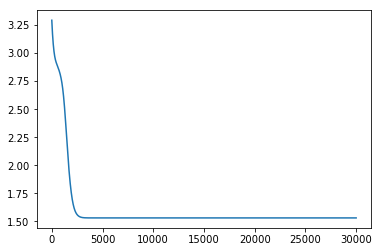

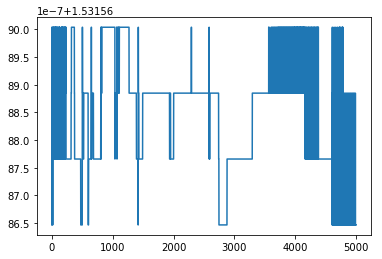

In [27]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
plt.plot(losses[5000:10000])
plt.show()

In [34]:
#[[0],[0],[1],[0]]
np.array(sess.run(output,feed_dict={X:X_data,y:y_data}))[:,0,:]

array([[ 0.46436268],
       [ 0.67353755],
       [ 0.03886279],
       [ 0.48474303]], dtype=float32)

In [33]:
#[[0],[1],[0],[0]]
np.array(sess.run(output,feed_dict={X:X_data,y:y_data}))[:,1,:]

array([[ 0.46436268],
       [-0.10235016],
       [ 0.40830663],
       [ 0.6522733 ]], dtype=float32)

In [36]:
#[[1],[0],[0],[1]]
np.array(sess.run(output,feed_dict={X:X_data,y:y_data}))[:,2,:]

array([[-0.39443445],
       [ 0.2315845 ],
       [ 0.57811087],
       [-0.02570706]], dtype=float32)

Note, that we are not really predicting enough, can you think why?

** Exercise: ** Fix it!